In [226]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from IPython.display import display, HTML

# filenames: ./logs/{topo}/{cc}/{0Mbps-0Mbps}/{0ms-0ms}/{rep}_{hostname}.txt
base_path = 'logs'
dir_path = './' + base_path + '/{}/{}/{}Mbps-{}Mbps/{}ms-{}ms/{}-'

def read_flow(sender_file_name, receiver_file_name):
    s = pd.read_csv(sender_file_name, sep='\t')
    r = pd.read_csv(receiver_file_name, sep='\t')
    # print(sender_file_name)
    df = pd.merge(s, r, how='outer', on='pkt_id')
    df['latency [s]'] = df['rcv_t [s]'] - df['snd_t [s]']
    df['latency [ms]'] = (df['rcv_t [s]'] - df['snd_t [s]']) * 1000
    df['sec'] = df['rcv_t [s]'] - df.at[(0, 'snd_t [s]')]
    df['disk_sec'] = df['sec'].apply(np.floor)
    df['disk_msec'] = df['sec'].apply(lambda x: np.floor(x * 1000))
    return df

def tp_array(df, bucket_size_ms=100):
    m = int(df['disk_msec'].max() / bucket_size_ms)
    byt, borders, _ = stats.binned_statistic(df['disk_msec'], df['payload [bytes]'], 'sum', bins=[i*bucket_size_ms for i in range(m)])
    ndf = pd.DataFrame({'msec': borders[:-1], 'tp [Mbps]': byt * 0.008 / bucket_size_ms})
    return ndf

def mean_tp(df, cutoff_s=2):
    latest_time = df['disk_msec'].max()
    df = tp_array(df)
    df = df[(df['msec'] >= cutoff_s*1e3) & (df['msec'] < latest_time - cutoff_s*1e3)]
    return df['tp [Mbps]'].mean()

def mean_latency(df, cutoff_s=2):
    latest_time = df['disk_msec'].max()
    df = df[(df['disk_msec'] > cutoff_s * 1000) & (df['disk_msec'] < latest_time - cutoff_s * 1000)]
    return df['latency [ms]'].mean()

# TODO enable single flow and multiflow loading
def load_experiments(topology, cc_algorithms, tps_a, tps_b, delays_a, delays_b, repetitions=3, postfix=''):
    df = pd.DataFrame()
    for cc in cc_algorithms:
        for tp_a in tps_a:
            for tp_b in tps_b:
                for delay_a in delays_a:
                    for delay_b in delays_b:
                        temp = pd.DataFrame()
                        for rep in range(repetitions):
                            # file name without host specified!
                            file_name = dir_path.format(topology, cc, tp_a, tp_b, delay_a, delay_b, rep)
                            # print(file_name + 'h2{}.txt'.format(postfix))
                            # if os.
                            flow1 = read_flow(file_name + 'h1{}.txt'.format(postfix), file_name + 'h2{}.txt'.format(postfix))
                            flow2 = read_flow(file_name + 'h3{}.txt'.format(postfix), file_name + 'h4{}.txt'.format(postfix))
                            temp = temp.append({
                                'cc': cc,
                                'tp_a': tp_a,
                                'tp_b': tp_b,
                                'delay_a': delay_a,
                                'delay_b': delay_b,
                                'rep': rep,
                                'mean_tp_flow1': mean_tp(flow1),
                                'mean_de_flow1': mean_latency(flow1),
                                'mean_tp_flow2': mean_tp(flow2),
                                'mean_de_flow2': mean_latency(flow2)
                            }, ignore_index=True)
                        # FIXME std of means is not good enough, calculate real std
                        df = df.append({
                            'cc': cc,
                            'tp_a': tp_a,
                            'tp_b': tp_b,
                            'delay_a': delay_a,
                            'delay_b': delay_b,
                            'mean_tp_flow1': temp['mean_tp_flow1'].mean(),
                            'std_tp_flow1': temp['mean_tp_flow1'].std(),
                            'mean_de_flow1': temp['mean_de_flow1'].mean(),
                            'std_de_flow1': temp['mean_de_flow1'].std(),
                            'mean_tp_flow2': temp['mean_tp_flow2'].mean(),
                            'std_tp_flow2': temp['mean_tp_flow2'].std(),
                            'mean_de_flow2': temp['mean_de_flow2'].mean(),
                            'std_de_flow2': temp['mean_de_flow2'].std()
                        }, ignore_index=True)
    return df


topologies = ['mptcp-host-pair', 'MPflow_lpkt','MPvsSP', 'MPvsSP_lpkt']
cc_algorithms = ['lia', 'olia', 'balia', 'wvegas', 'cubic']

# Chaning Latency Analysis

In [236]:
# OLD!
# logs/mptcp-host-pair/balia/1ms-1ms/0-h1.txt

topo = 'mptcp-host-pair'

tmp_dir_path = './' + base_path + '/{}/{}/{}ms-{}ms/{}-'

df = pd.DataFrame([])

delays = np.arange(1, 101, 20)
# delays = np.arange(1, 102, 10)
tp = 10

# FIXME cubic not included!
for cc in cc_algorithms[:-1]:
    for delay_a in delays[:3]:
        for delay_b in [d for d in delays if d >= delay_a]:
            temp_df = pd.DataFrame()
            for rep in range(3):
                # file name without host specified!
                # file_name = dir_path.format(topo, cc, tp, tp, d_a, d_b, rep)
                file_name = tmp_dir_path.format(topo, cc, delay_a, delay_b, rep)
                flow = read_flow(file_name + 'h1.txt', file_name + 'h2.txt')
                temp_df = temp_df.append({
                    'cc': cc,
                    'delay_a': delay_a,
                    'delay_b': delay_b,
                    'rep': rep,
                    'mean_tp': mean_tp(flow),
                    'mean_de': mean_latency(flow)
                }, ignore_index=True)
                # print(flow)
            df = df.append({
                'cc': cc,
                'delay_a': delay_a,
                'delay_b': delay_b,
                'mean_tp': temp_df['mean_tp'].mean(),
                'std_tp': temp_df['mean_tp'].std(),
                'mean_de': temp_df['mean_de'].mean(),
                'std_de': temp_df['mean_de'].std(),
            }, ignore_index=True)

df

,cc,delay_a,delay_b,mean_de,mean_tp,std_de,std_tp
0,lia,1.0,1.0,3590.752859,10.505276,6169.646950,7.284583
1,lia,1.0,21.0,42.470840,9.865322,0.124531,0.028878
2,lia,1.0,41.0,47.547644,9.187214,0.652207,0.169705
3,lia,1.0,61.0,47.821120,8.861760,0.504936,0.117377
4,lia,1.0,81.0,47.319432,8.993266,0.232996,0.024583
5,lia,21.0,21.0,65.513020,5.018282,0.274773,0.019057
6,lia,21.0,41.0,88.405044,4.053426,1.837948,0.061731
7,lia,21.0,61.0,134.918665,2.767287,0.741406,0.024916
8,lia,21.0,81.0,118.094581,3.036939,3.072546,0.046154
9,lia,41.0,41.0,124.229030,2.643974,0.410196,0.004010


In [237]:
# logs/mptcp-host-pair/balia/1ms-1ms/0-h1.txt

topo = 'mptcp-host-pair'

df = pd.DataFrame([])

delays = np.arange(1, 102, 20)
tp = 10

# df = load_experiments(topo, cc_algorithms, [10], [10], delays, delays)

for cc in cc_algorithms:
    for delay_a in delays:
        for delay_b in delays:
            temp_df = pd.DataFrame()
            for rep in range(1): # TODO reenable repetitions 3
                # file name without host specified!
                file_name = dir_path.format(topo, cc, tp, tp, delay_a, delay_b, rep)
                flow = read_flow(file_name + 'h1.txt', file_name + 'h2.txt')
                temp_df = temp_df.append({
                    'cc': cc,
                    'delay_a': delay_a,
                    'delay_b': delay_b,
                    'rep': rep,
                    'mean_tp': mean_tp(flow),
                    'mean_de': mean_latency(flow)
                }, ignore_index=True)
                # print(flow)
            df = df.append({
                'cc': cc,
                'delay_a': delay_a,
                'delay_b': delay_b,
                'mean_tp': temp_df['mean_tp'].mean(),
                'std_tp': temp_df['mean_tp'].std(),
                'mean_de': temp_df['mean_de'].mean(),
                'std_de': temp_df['mean_de'].std(),
            }, ignore_index=True)

df

,cc,delay_a,delay_b,mean_de,mean_tp,std_de,std_tp
0,lia,1.0,1.0,30.080945,14.007488,NaN,NaN
1,lia,1.0,21.0,54.680909,7.517236,NaN,NaN
2,lia,1.0,41.0,56.571319,7.613353,NaN,NaN
3,lia,1.0,61.0,66.294527,6.242676,NaN,NaN
4,lia,1.0,81.0,50.743423,8.350516,NaN,NaN
5,lia,1.0,101.0,52.863045,7.950575,NaN,NaN
6,lia,21.0,1.0,52.983849,7.809047,NaN,NaN
7,lia,21.0,21.0,96.017819,3.581665,NaN,NaN
8,lia,21.0,41.0,104.818674,3.476073,NaN,NaN
9,lia,21.0,61.0,189.135194,1.994118,NaN,NaN


In [238]:
# iperf csv
# timestamp,source_address,source_port,destination_address,destination_port,interval,transferred_bytes,bits_per_second
def read_iperf(sender_file_name, receiver_file_name):
    header_names = ['timestamp','source_address','source_port','destination_address',
                    'destination_port','xxx','interval','transferred_bytes','bits_per_second']
    s = pd.read_csv(sender_file_name, names=header_names, index_col=False)
    s['Mbps'] = s['bits_per_second'] / 1000000
    return s

# TODO: remove when more data is available
def load_iperf_experiments(topology, cc_algorithms, tps_a, tps_b, delays_a, delays_b, repetitions=range(3)):
    df = pd.DataFrame()
    for cc in cc_algorithms:
        for tp_a in tps_a:
            for tp_b in tps_b:
                for delay_a in delays_a:
                    for delay_b in delays_b:
                        temp = pd.DataFrame()
                        for rep in repetitions:
                            # file name without host specified!
                            file_name = dir_path.format(topology, cc, tp_a, tp_b, delay_a, delay_b, rep)
                            flow1 = read_iperf(file_name + 'h1_iperf.txt', file_name + 'h2_iperf.txt')
                            # flow2 = read_iperf(file_name + 'h3_iperf.txt', file_name + 'h4_iperf.txt')
                            temp = temp.append({
                                'mean_tp_flow1': flow1['Mbps'],
                                # 'mean_tp_flow2': flow2['Mbps'],
                                # 'mean_de_flow2': mean_latency(flow2)
                            }, ignore_index=True)
                        # FIXME: std of means is not good enough, calculate real std
                        df = df.append({
                            'cc': cc,
                            'tp_a': tp_a,
                            'tp_b': tp_b,
                            'delay_a': delay_a,
                            'delay_b': delay_b,
                            'mean_tp_flow1': temp['mean_tp_flow1'].mean(),
                            'std_tp_flow1': temp['mean_tp_flow1'].std(),
                            # 'mean_de_flow1': temp['mean_de_flow1'].mean(),
                            # 'std_de_flow1': temp['mean_de_flow1'].std(),
                            # 'mean_tp_flow2': temp['mean_tp_flow2'].mean(),
                            # 'std_tp_flow2': temp['mean_tp_flow2'].std(),
                            # 'mean_de_flow2': temp['mean_de_flow2'].mean(),
                            # 'std_de_flow2': temp['mean_de_flow2'].std()
                        }, ignore_index=True)
    return df
    
delays = np.arange(1, 102, 20)
read_iperf('./logs/mptcp-host-pair/lia/10Mbps-10Mbps/1ms-21ms/0-h1_iperf.txt', '')

df_iperf = load_iperf_experiments('mptcp-host-pair', cc_algorithms, [10], [10], delays, delays, repetitions=[0])
df_iperf

,cc,delay_a,delay_b,mean_tp_flow1,std_tp_flow1,tp_a,tp_b
0,lia,1.0,1.0,18.707105,NaN,10.0,10.0
1,lia,1.0,21.0,18.098852,NaN,10.0,10.0
2,lia,1.0,41.0,20.104711,NaN,10.0,10.0
3,lia,1.0,61.0,20.446060,NaN,10.0,10.0
4,lia,1.0,81.0,16.507069,NaN,10.0,10.0
5,lia,1.0,101.0,20.006184,NaN,10.0,10.0
6,lia,21.0,1.0,19.548055,NaN,10.0,10.0
7,lia,21.0,21.0,14.556000,NaN,10.0,10.0
8,lia,21.0,41.0,17.419554,NaN,10.0,10.0
9,lia,21.0,61.0,14.484213,NaN,10.0,10.0


Text(0.5, 0, 'ms delay of second link')

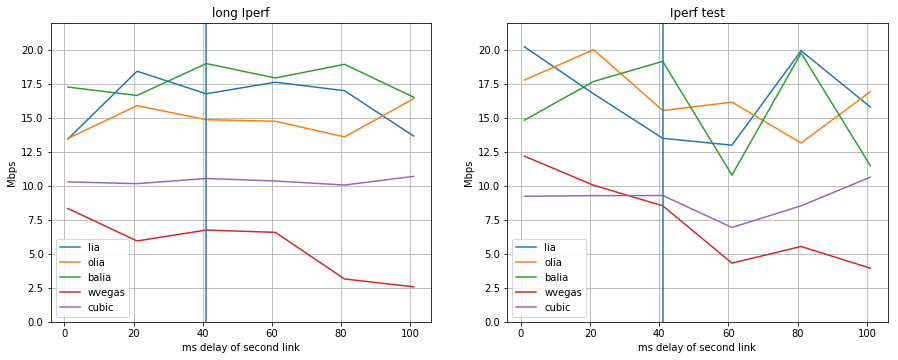

In [239]:
## comparing different iperf runtimes
delay_point = 41

delays = np.arange(1, 102, 20)

df_iperf_long = load_iperf_experiments('mptcp-host-pair', cc_algorithms, [10], [10],
                                       [delay_point], delays, repetitions=[9])


x_liperf = df_iperf_long[df_iperf_long['delay_a'] == delay_point]
x_iperf = df_iperf[df_iperf['delay_a'] == delay_point]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5.5))

for cc in x_liperf['cc'].unique():
    tmp = x_liperf[x_liperf['cc'] == cc]
    tmp.plot(x='delay_b', y='mean_tp_flow1', label=cc, ax=axes[0], legend=True, grid=True, ylim=(0,22))

axes[0].set_title('long Iperf')
axes[0].axvline(delay_point)
axes[0].set_ylabel('Mbps')
axes[0].set_xlabel('ms delay of second link')

for cc in x_iperf['cc'].unique():
    tmp = x_iperf[x_iperf['cc'] == cc]
    tmp.plot(x='delay_b', y='mean_tp_flow1', label=cc, ax=axes[1], legend=True, grid=True, ylim=(0,22))

axes[1].set_title('Iperf test')
axes[1].set_ylabel('Mbps')
axes[1].axvline(delay_point)
axes[1].set_xlabel('ms delay of second link')

Text(0.5, 0, 'ms delay of second link')

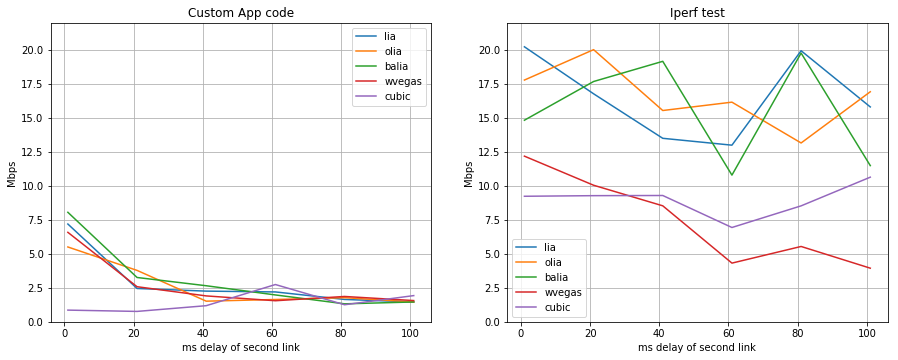

In [240]:
## comparing app with iperf
d = 41

x = df[df['delay_a'] == d]
x_iperf = df_iperf[df_iperf['delay_a'] == d]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5.5))

for cc in x['cc'].unique():
    tmp = x[x['cc'] == cc]
    tmp.plot(x='delay_b', y='mean_tp', label=cc, ax=axes[0], legend=True, grid=True, ylim=(0,22))

axes[0].set_title('Custom App code')
axes[0].set_ylabel('Mbps')
axes[0].set_xlabel('ms delay of second link')
    
for cc in x_iperf['cc'].unique():
    tmp = x_iperf[x_iperf['cc'] == cc]
    tmp.plot(x='delay_b', y='mean_tp_flow1', label=cc, ax=axes[1], legend=True, grid=True, ylim=(0,22))

axes[1].set_title('Iperf test')
axes[1].set_ylabel('Mbps')
axes[1].set_xlabel('ms delay of second link')

# Changing Throughput Ananlysis

In [227]:
tps_a = [5, 10, 15]
tps_b = [5, 10, 15]

df = pd.DataFrame()
delay = 10
topo = 'mp-vs-sp'

df1 = load_experiments(topo, cc_algorithms[:-1], tps_a, tps_b, [delay], [delay])
df2 = load_experiments(topo, cc_algorithms[:-1], tps_a, tps_b, [delay], [delay], postfix='big')
df2

,cc,delay_a,delay_b,mean_de_flow1,mean_de_flow2,mean_tp_flow1,mean_tp_flow2,std_de_flow1,std_de_flow2,std_tp_flow1,std_tp_flow2,tp_a,tp_b
0,lia,10.0,10.0,86.517998,110.789882,4.531358,3.630617,0.530903,0.272778,0.027654,0.003951,5.0,5.0
1,lia,10.0,10.0,62.363120,50.051668,6.022360,7.253333,0.995604,0.331145,0.071883,0.055699,5.0,10.0
2,lia,10.0,10.0,50.922681,41.423465,7.153954,8.472381,0.055081,0.169272,0.040798,0.031884,5.0,15.0
3,lia,10.0,10.0,75.030998,104.517470,5.276021,3.817490,0.438205,0.544994,0.014838,0.021910,10.0,5.0
4,lia,10.0,10.0,42.326019,48.285062,8.350476,7.485217,0.459717,0.182929,0.033338,0.026067,10.0,10.0
5,lia,10.0,10.0,33.226611,37.083745,9.990890,9.239586,0.249967,0.051357,0.040604,0.011475,10.0,15.0
6,lia,10.0,10.0,76.212261,103.986881,5.194203,3.830782,0.407292,0.227818,0.064384,0.009942,15.0,5.0
7,lia,10.0,10.0,42.194801,48.193870,8.375652,7.494493,0.715135,0.361438,0.099379,0.053970,15.0,10.0
8,lia,10.0,10.0,33.296261,37.179007,9.945839,9.215735,0.144098,0.049184,0.010517,0.004590,15.0,15.0
9,olia,10.0,10.0,86.456276,109.695577,4.549958,3.659588,0.197454,0.338949,0.010171,0.006035,5.0,5.0


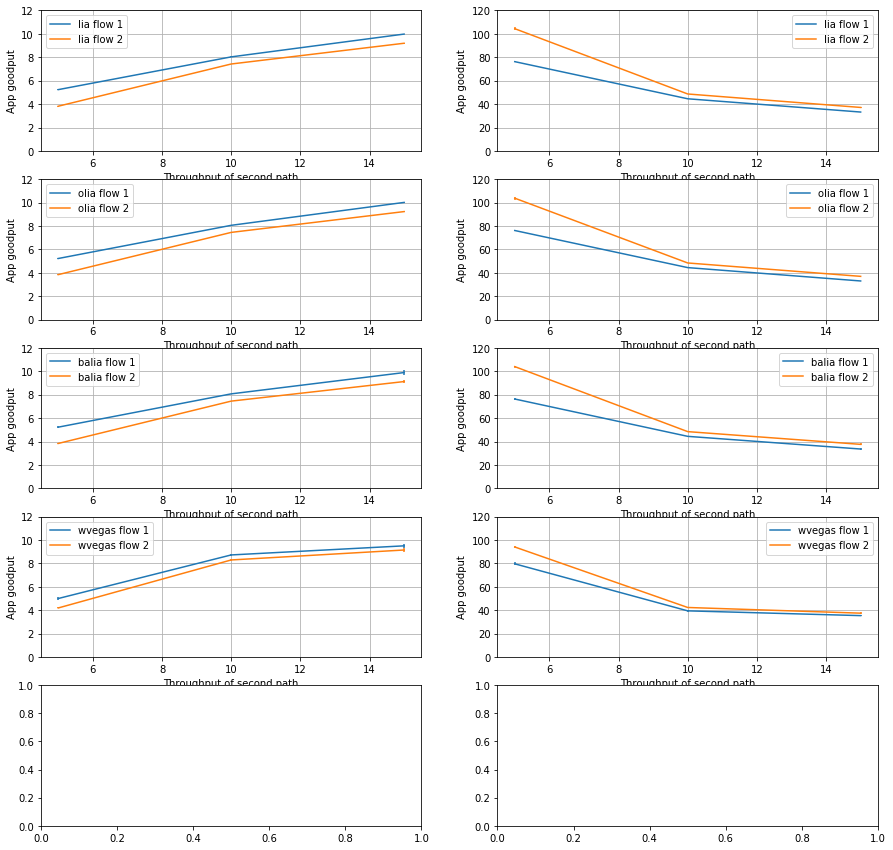

In [228]:
x = df1[df1['tp_a'] == 15]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for i, cc in enumerate(x['cc'].unique()):
    for flow in [1, 2]:
        ax = x[x['cc'] == cc].plot(x='tp_b', y='mean_tp_flow{}'.format(flow), yerr='std_tp_flow{}'.format(flow),
                                  label='{} flow {}'.format(cc, flow), ax=axes[i, 0], grid=True, ylim=(0,12))
        ax.set_ylabel('App goodput')
        ax.set_xlabel('Throughput of second path')

        
for i, cc in enumerate(x['cc'].unique()):
    for flow in [1, 2]:
        ax = x[x['cc'] == cc].plot(x='tp_b', y='mean_de_flow{}'.format(flow), yerr='std_de_flow{}'.format(flow),
                              label='{} flow {}'.format(cc, flow), ax=axes[i, 1], grid=True, ylim=(0,120))
        ax.set_ylabel('App goodput')
        ax.set_xlabel('Throughput of second path')


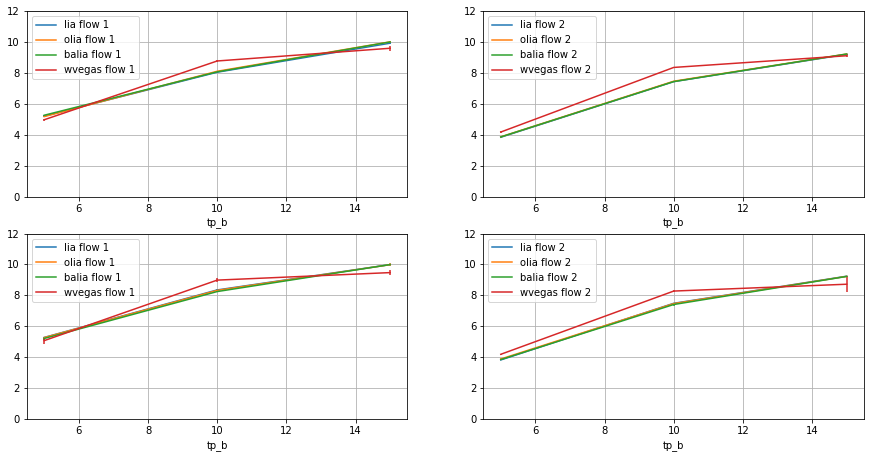

In [229]:
## compare big with small pkt sizes, top and bottom charts similiar => no difference between sending small and big pkts
x = df1[df1['tp_a'] == 10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7.5))

for cc in x['cc'].unique():
    for flow in [1, 2]:
        x[x['cc'] == cc].plot(x='tp_b', y='mean_tp_flow{}'.format(flow), yerr='std_tp_flow{}'.format(flow),
                              label='{} flow {}'.format(cc, flow), ax=axes[0,flow-1], grid=True, ylim=(0,12))

x = df2[df2['tp_a'] == 10]

for cc in x['cc'].unique():
    for flow in [1, 2]:
        x[x['cc'] == cc].plot(x='tp_b', y='mean_tp_flow{}'.format(flow), yerr='std_tp_flow{}'.format(flow),
                              label='{} flow {}'.format(cc, flow), ax=axes[1,flow-1], grid=True, ylim=(0,12))
